In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(699)

In [3]:
expiry = 1
num_steps = 100
num_paths = 5
spot_price = 10
spot_price_frac = 0.3
rate = 0.05
vol = 0.25

In [4]:
data = training_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol)

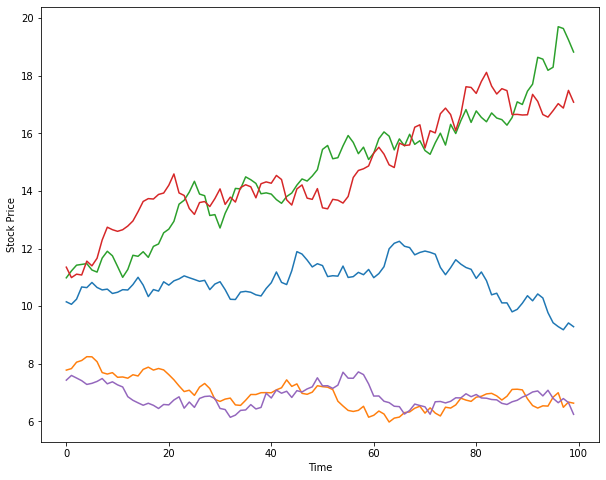

In [76]:
plt.figure(figsize=(10, 8))
for d in data:
    plt.plot([i[0] for i in d], [i[1] for i in d])
plt.xlabel('Time');
plt.ylabel('Stock Price');

In [420]:
def training_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
        
    Data = []
    dt = expiry/num_steps
    spot = spot_price
    vol2 = np.square(vol)
    mean2 = np.square(spot)
    var = mean2*np.square(spot_price_frac)
    
    log_mean = np.log(mean2) - 0.5*np.log(var + mean2) 
    log_stdev = np.sqrt(np.log(var/mean2 + 1))
    
    for _ in range(num_paths):
        data = []
        price = np.random.lognormal(log_mean, log_stdev)
        for step in range(num_steps):
            m = np.log(price) + (rate - vol2/2)*dt
            v = vol2*dt
            next_price = np.exp(np.random.normal(m, np.sqrt(v)))
            data.append((step, price, next_price))
            price = next_price
        Data.append(data)
    return Data

In [421]:
class Basisfunction():
    def __init__(self):
        pass

    def lauguaree(self, s, K, t, expiry):
        M = s/K
        e = np.exp(-M/2)
        diff = expiry - t
        return np.array([1, 
                         e, 
                         e*(1-M), 
                         e*(1-2*M+(M*M/2)), 
                         np.cos(np.pi*diff/(2*expiry)), 
                         np.log(diff) if diff>0 else 0, 
                         np.square(t/expiry)
                        ])

    def fourier(self, s, a):
        pass
    
    def identity(self, s, K, t, expiry):
        pass
        

In [500]:
class LSPI():
    def __init__(self, basis, k, eps=1e-2, option_type='put'):
        self.option_type = option_type # or 'call'
        
        self.eps = eps
        self.phi = basis
        self.k = k
        self.w = np.zeros((k, 1))
        self.P_inv = np.eye(self.k)/self.eps
        self.q = None
        self.Phi = None
    
    def generate_data(self, expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, seed=69):

        np.random.seed(seed)
        
        self.data = training_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol)
        
        self.training_data = []
        for d in self.data:
            self.training_data += d
        self.dt = expiry/num_steps
        
        self.state = np.array([(i*self.dt, x) for i, x, _ in self.training_data])
        self.next_state = np.array([(i*self.dt, x) for i, _, x in self.training_data])
        self.non_terminal = np.array([i < num_steps-1 for i, _, _ in self.training_data])
#         print([(i, num_steps) for i, _, _ in self.training_data])
        self.phi_s = np.array([self.phi(s, strike, t, expiry) for t, s in self.state])
#         print(self.phi_s.shape)
        self.phi_next_s = np.array([self.phi(s, strike, t, expiry) for t, s in self.next_state])
        
        self.exer = None
        if self.option_type == 'put':
            self.exer = np.array([max(strike-s1, 0) for _, s1 in self.state])
        else:
            self.exer = np.array([max(s1-strike, 0) for _, s1 in self.state])
#         if self.option_type == 'put':
#             self.exer = np.array([strike-s1 for _, s1 in self.state])
#         else:
#             self.exer = np.array([s1-strike for _, s1 in self.state])
        
    def optimal_policy(self, s, strike, t, expiry):
        exer = max(strike-s, 0) if self.option_type=='put' else max(s-strike, 0)
#         exer = strike-s if self.option_type=='put' else s-strike
        payoff = [(self.phi(s, strike, t, expiry)@self.w)[0], exer]
        return np.max(payoff), np.argmax(payoff), payoff

    def train(self, expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=1, r=0.03, plot=True):
        self.w = np.ones((self.k, 1))
        self.loss = [np.linalg.norm(self.w)]
        self.generate_data(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike)
#         self.gamma = np.exp(-rate*self.dt)
#         self.gamma = np.exp(-rate)
        self.gamma = np.exp(-1*r)
        
        
            
        for _ in range(ITR):
            self.P_inv = np.eye(self.k)/self.eps
            self.q = np.zeros((self.k, 1))
            Q = self.phi_next_s@self.w
            C1 = self.non_terminal * (Q[:, 0] > self.exer)
#             print(C1[np.logical_not(self.non_terminal)], Q[np.logical_not(self.non_terminal)], self.exer[np.logical_not(self.non_terminal)])
            for i in range(len(self.training_data)):
                phi_1 = self.phi_s[i].reshape(-1, 1)
                 
                phi_2 = phi_1 - (C1[i]*self.gamma*self.phi_next_s[i]).reshape(-1, 1)
                
                temp = self.P_inv.T@phi_2
                
                self.P_inv -= self.P_inv@phi_1@temp.T / (1 + temp.T@phi_1)
                self.q += phi_1 * (1 - C1[i]) * self.exer[i] * self.gamma
            self.w = self.P_inv@self.q
            self.loss.append(np.linalg.norm(self.w))
        
        if plot:
            plt.figure(figsize=(10, 8))
            plt.title('Convergence of weights', fontsize=15)
            plt.ylabel(r'$|w|_2$', fontsize=15)
            plt.xlabel('Iterations', fontsize=15)
            plt.semilogy(self.loss)
        return self.w
                

In [501]:
expiry = 1
num_steps = 252
num_paths = 500
spot_price = 11
spot_price_frac = 0.01
rate = 0.05
vol = 0.2

strike = 10
option_type = 'put'

In [502]:
basis_class = Basisfunction()
basis = basis_class.lauguaree
os_problem = LSPI(basis, 7, eps=1e-3, option_type=option_type)

array([[-5.38212359e+01],
       [ 1.15070554e+02],
       [-8.86084185e+01],
       [ 5.11070704e+01],
       [ 5.51075807e-03],
       [ 4.36613055e-02],
       [ 1.40434185e-01]])

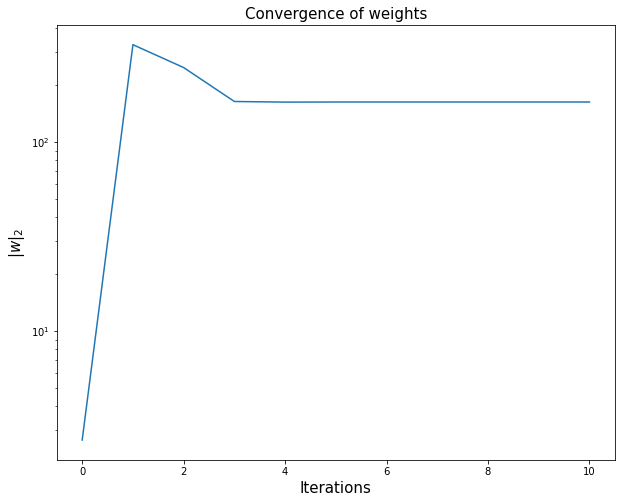

In [503]:
os_problem.train(expiry, num_steps, num_paths, spot_price, spot_price_frac, rate, vol, strike, ITR=10)

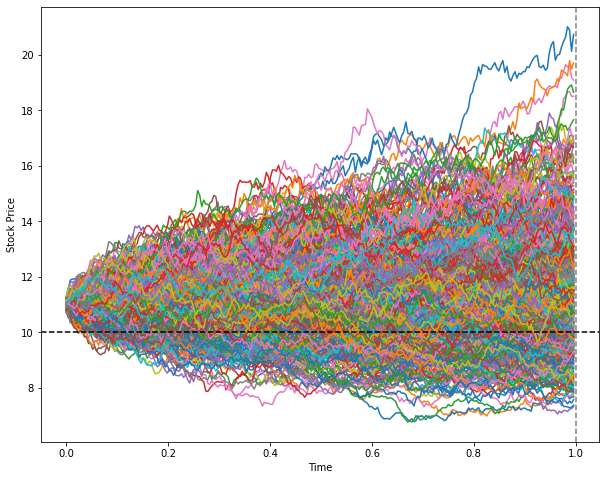

In [504]:
plt.figure(figsize=(10, 8))
for d in os_problem.data:
    plt.plot([i[0]*expiry/num_steps for i in d], [i[1] for i in d])
plt.axhline(strike, color='black', linestyle='--')
plt.axvline(expiry, color='grey', linestyle='--')
plt.xlabel('Time');
plt.ylabel('Stock Price');

In [505]:
Ss_len = 300
Ts_len = 300

min_stock = 8
max_stock = strike+0.1
min_time = 0
max_time = expiry

Ss = np.linspace(min_stock, max_stock, Ss_len)
Ts = np.linspace(min_time, max_time, Ts_len)

In [514]:
pol = np.zeros((Ss_len, Ts_len))
payoff = np.zeros((Ss_len, Ts_len))
for i in range(pol.shape[0]):
    for j in range(pol.shape[1]):
        payoff[i, j], pol[i, j], _ = os_problem.optimal_policy(Ss[i], strike, Ts[j], expiry)
excersise_boundary = [Ss[np.where(pol[:, i]==1)[0][-1]] for i in range(Ts_len)]


Text(0, 0.5, 'Stock Price')

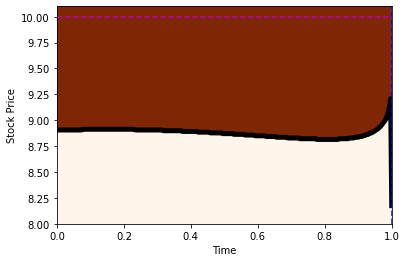

In [538]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(pol, cmap='Oranges_r', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')

ax.plot(Ts, excersise_boundary, c='black', linewidth=5)
ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

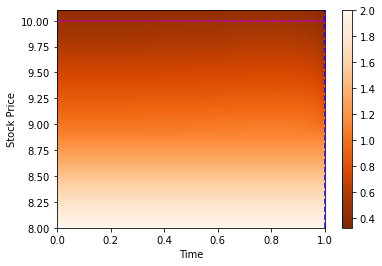

In [540]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(payoff, cmap='Oranges_r', origin='lower', extent=[min_time, max_time, min_stock, max_stock], aspect='auto')
plt.colorbar(img)

ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

# Finite-MDP with Binomial Option Pricing

In [766]:
class BOP_MDP():
    def __init__(self, num_steps, expiry, rate, vol, spot_price, end_price, strike, s_n):
        self.num_steps = num_steps
        self.expiry = expiry
        self.rate = rate
        self.vol = vol
        self.s_n = s_n
        self.spot_price = spot_price
        self.end_price = end_price
        
        self.dt = expiry/num_steps
        self.gamma = np.exp(-self.rate*self.dt)
        self.up_factor = np.exp(self.vol * np.sqrt(self.dt))
        self.up_prob = (np.exp(self.rate * self.dt) * self.up_factor - 1) / \
                        (self.up_factor * self.up_factor - 1)
        
        self.V = -np.inf*np.ones((s_n, num_steps))
        self.PI = np.zeros((s_n, num_steps)).astype(int)
        
        self.T = np.linspace(0, expiry, num_steps)
        
    def g(self, s):
        s = np.asarray(s)
        c = strike - s
        pi = c > 0
        c[np.logical_not(pi)] = 0
        return pi, c
    
    def find_closest(self, arr, x, tol=1e-3):
        b = np.abs(arr - x)
        i = np.argmin(b)
        
        e = b[i]
        if e <= tol:
            return i
        return None
    
    def stock_price(self, i, j):
        return self.spot_price*np.exp((2*j - i)*self.vol*np.sqrt(self.dt))
    
    def backprop(self):
        self.S = np.array([[self.stock_price(i, j) for j in range(self.num_steps)] for i in range(self.s_n)])
        
        self.PI[:, -1], self.V[:, -1] = self.g(self.S[:, -1])
        
        for t in range(self.num_steps - 1):
            for i in range(self.s_n):
                expect_V_fut = self.up_prob*(self.V[u_idx, t+1] + self.V[d_idx, t+1])
                
                poss_V = np.array([self.gamma*expect_V_fut, \
                                   self.g([self.S[i, t]])[1]])
                
                self.PI[i, t] = int(np.argmax(poss_V))
                self.V[i, t] = poss_V[self.PI[i, t]]
        
    
    def optimal_exercise_boundry(self):
        pass
        

In [776]:
expiry = 1
num_steps = 100
rate = 0.05
vol = 0.25

strike = 10
spot_price = 10
end_price = strike + 2
s_n = 100

In [777]:
f_mdp = BOP_MDP(num_steps, expiry, rate, vol, spot_price, end_price, strike, s_n)

In [778]:
f_mdp.stock_price(0, 100)

1484.131591025766

In [779]:
f_mdp.backprop()

/tmp/ipykernel_42557/2059529699.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poss_V = np.array([self.gamma*expect_V_fut, \


In [780]:
f_mdp.up_factor

1.0253151205244289

In [781]:
f_mdp.S

array([[1.00000000e+01, 1.05127110e+01, 1.10517092e+01, ...,
        1.27740390e+03, 1.34289780e+03, 1.41174964e+03],
       [9.75309912e+00, 1.02531512e+01, 1.07788415e+01, ...,
        1.24586468e+03, 1.30974153e+03, 1.37689342e+03],
       [9.51229425e+00, 1.00000000e+01, 1.05127110e+01, ...,
        1.21510418e+03, 1.27740390e+03, 1.34289780e+03],
       ...,
       [8.84781190e-01, 9.30144892e-01, 9.77834441e-01, ...,
        1.13022294e+02, 1.18817071e+02, 1.24908953e+02],
       [8.62935865e-01, 9.07179533e-01, 9.53691622e-01, ...,
        1.10231764e+02, 1.15883467e+02, 1.21824940e+02],
       [8.41629903e-01, 8.84781190e-01, 9.30144892e-01, ...,
        1.07510132e+02, 1.13022294e+02, 1.18817071e+02]])

In [782]:
f_mdp.up_prob

0.5037517840660495

In [783]:
f_mdp.V[:, -2:]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [753]:
f_mdp.PI

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0]])

/tmp/ipykernel_42557/2142919092.py:3: UserWarning: Attempting to set identical bottom == top == 12 results in singular transformations; automatically expanding.
  img = ax.imshow(f_mdp.V, cmap='gray', origin='lower', extent=[0, expiry, spot_price, end_price], aspect='auto')


Text(0, 0.5, 'Stock Price')

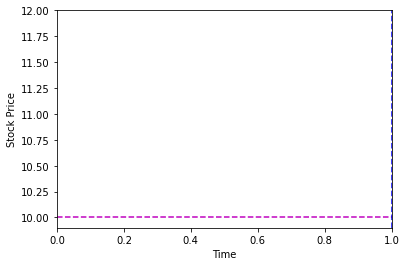

In [754]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(f_mdp.V, cmap='gray', origin='lower', extent=[0, expiry, spot_price, end_price], aspect='auto')

ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

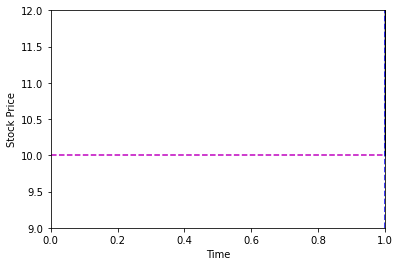

In [700]:
fig, ax = plt.subplots(1, 1)

img = ax.imshow(f_mdp.PI, cmap='gray', origin='lower', extent=[0, expiry, spot_price, end_price], aspect='auto')

ax.axhline(strike, linestyle='--', color='m')
ax.axvline(1.0, linestyle='--', color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')

In [569]:
a = np.linspace(0, 1, 10)

In [572]:
np.isclose(a, 0.1, rtol=1e-3)

array([False, False, False, False, False, False, False, False, False,
       False])

In [573]:
a

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])